In [1]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster, Client, progress
import xarray as xr
from src.load_SAIdata import Cases
from src.meridional_mass_flux import meridional_mass_flux
%matplotlib inline

In [2]:
%%time
ds = {}
for exp,tslice in zip(['ref','cnt','sai'],[slice('2003','2007'),slice('2093','2097'),slice('2093','2097')]):
    ds[exp] = xr.concat([
        Cases(f'hres.{exp}.{ens}').select('atm','h0').open_mfdataset().assign_coords(ens=ens).sel(time=tslice) 
        for ens in range(1,7)
    ], dim='ens')

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.cam2.h0.2002-12_2012-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.004.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.005.cam2.h0.2002-12_2008-02.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.0

In [3]:
MMF = {}
for exp in ds:
    P = ds[exp].hyam * ds[exp].P0 + ds[exp].hybm * ds[exp].PS
    MMF[exp] = meridional_mass_flux(ds[exp].V, P, ds[exp].lat)

MMFzm = {exp: MMF[exp].mean(('lon','ens')).groupby('time.month').mean() for exp in MMF}
#MMFzm = {exp: MMF[exp].isel(lon=0,ens=0).groupby('time.month').mean() for exp in MMF}

In [ ]:
cluster = LocalCluster()
client = Client(cluster )

MMFzm = {exp: MMFzm[exp].persist() for exp in MMF}
progress(*MMFzm.values(), multi=False)

In [35]:
MMFzm = {exp: MMFzm[exp].compute() for exp in MMFzm}
client.shutdown()

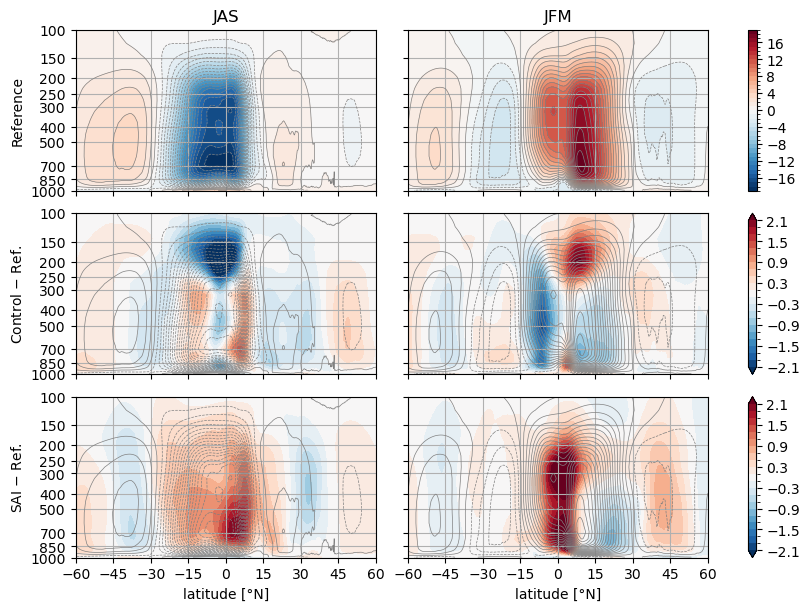

In [36]:
fig,axs = plt.subplots(3,2,layout='constrained', sharex=True, sharey=True, figsize=(8,6)) 

MMFzmJAS = {exp: MMFzm[exp].sel(month=[7,8,9]).mean('month')/1e10 for exp in MMFzm}
MMFzmJFM = {exp: MMFzm[exp].sel(month=[1,2,3]).mean('month')/1e10 for exp in MMFzm}

levels_ref = np.arange(-19,19.1,1)
levels_dif = np.arange(-2.1,2.11,.2)

ax = axs.flat[0]
p_r = MMFzmJAS['ref'].plot.contourf(ax=ax, y='lev', yincrease=False, yscale='log', levels=levels_ref, add_colorbar=False)
p_rc = MMFzmJAS['ref'].plot.contour(ax=ax, y='lev', yincrease=False, yscale='log', levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)

ax = axs.flat[1]
p_r = MMFzmJFM['ref'].plot.contourf(ax=ax, y='lev', yincrease=False, yscale='log', levels=levels_ref, add_colorbar=False)
p_rc = MMFzmJFM['ref'].plot.contour(ax=ax, y='lev', yincrease=False, yscale='log', levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)

ax = axs.flat[2]
p_cr = (MMFzmJAS['cnt']-MMFzmJAS['ref']).plot.contourf(ax=ax, y='lev', yincrease=False, yscale='log',levels=levels_dif , extend='both',  add_colorbar=False)
p_rc = MMFzmJAS['ref'].plot.contour(ax=ax, y='lev', yincrease=False, yscale='log', levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)

ax = axs.flat[3]
p_cr = (MMFzmJFM['cnt']-MMFzmJFM['ref']).plot.contourf(ax=ax, y='lev', yincrease=False, yscale='log',levels=levels_dif , extend='both',  add_colorbar=False)
p_rc = MMFzmJFM['ref'].plot.contour(ax=ax, y='lev', yincrease=False, yscale='log', levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)

ax = axs.flat[4]
p_sr = (MMFzmJAS['sai']-MMFzmJAS['ref']).plot.contourf(ax=ax, y='lev', yincrease=False, yscale='log',levels=levels_dif , extend='both', add_colorbar=False)
p_rc = MMFzmJAS['ref'].plot.contour(ax=ax, y='lev', yincrease=False, yscale='log', levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)

ax = axs.flat[5]
p_sr = (MMFzmJFM['sai']-MMFzmJFM['ref']).plot.contourf(ax=ax, y='lev', yincrease=False, yscale='log',levels=levels_dif , extend='both', add_colorbar=False)
p_rc = MMFzmJFM['ref'].plot.contour(ax=ax, y='lev', yincrease=False, yscale='log', levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)

for ax in axs.flat:
    ax.set_ylim([1000,100])
    ax.set_xlim([-60,60])
    ax.set_xticks(range(-60,61,15))
    ax.set_yticks([], minor=True)
    ax.set_yticks([1000,850,700,500,400,300,250,200,150,100], labels=['1000','850','700','500','400','300','250','200','150','100'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid()

axs[-1,0].set_xlabel('latitude [°N]')
axs[-1,1].set_xlabel('latitude [°N]')
axs[0,0].set_ylabel('Reference')
axs[1,0].set_ylabel('Control $-$ Ref.')
axs[2,0].set_ylabel('SAI $-$ Ref.')
axs[0,0].set_title('JAS')
axs[0,1].set_title('JFM')


cb1 = fig.colorbar(p_r, ax=axs.flat[:2])
cb2 = fig.colorbar(p_cr, ax=axs.flat[2:4])
cb3 = fig.colorbar(p_sr, ax=axs.flat[4:6])
cb2.ax.set_yticks([-2.1,-1.5,-0.9,-0.3,0.3,0.9,1.5,2.1])
cb3.ax.set_yticks([-2.1,-1.5,-0.9,-0.3,0.3,0.9,1.5,2.1])

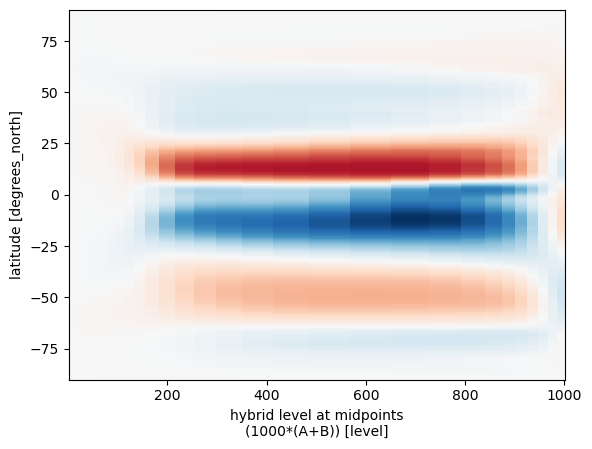

In [12]:
MMFzm['ref'].mean('ens').plot(add_colorbar=False)

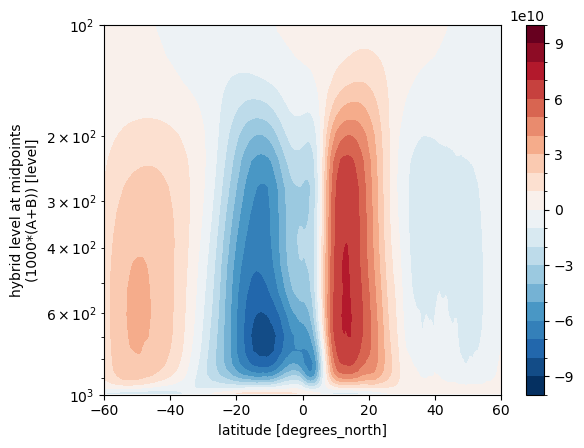

In [20]:
MMFzm.plot.contourf(y='lev', yincrease=False, yscale='log', ylim=[1000,100], xlim=[-60,60], levels=np.arange(-10e10,10.1e10,1e10))

In [21]:
MMFvm = MMF.mean(('lev','time')).persist()
progress(MMFvm)

VBox()

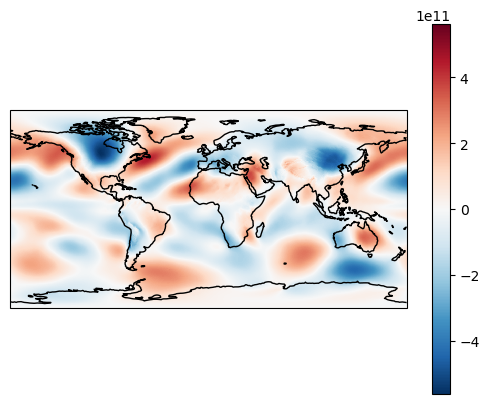

In [26]:
ax = plt.axes(projection=ccrs.PlateCarree())
MMFvm.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()